# Lung TCP Model 

This notebook builds upon the research of Jeong et al, demonstrating that a mechanistic, mathematical model has the capability to precisely forecast the significant variations in treatment response observed within early-stage lung cancer, when considering a variety of clinical doses and fractionation schemes.

This model can predict the probability of achieving local tumor control based on factors such as dose and treatment fractions, and examines the interaction between cell hypoxia, proliferation, and radiation dose distribution to predict treatment outcomes. The model came about as a response to the poorly understood, but significant, variation of tumor sterilization rates exhibited among different fractionation schemes and can be used to predict which fractionation schemes over- or undertreat lung tumors.

### References

- Jeong, J., K. I. Shoghi, and J. O. Deasy. "Modelling the interplay between hypoxia and proliferation in radiotherapy tumour response." Physics in Medicine & Biology 58.14 (2013): 4897-4919.
- Jeong, Jeho, et al. "Modeling the cellular response of lung cancer to radiation therapy for a broad range of fractionation schedules." Clinical Cancer Research 23.18 (2017): 5469-5479.

## Define Model Parameters

The cell below defines the model parameters for lung cancer. Since most of the model's parameters do not significantly influence the model fit they are defined once based on other publications or plausibility.

Optimal values of $\alpha$ (alpha_p_ori), $\frac{\alpha}{\beta}$ (a_over_b), and the oxygen enhancement ratio of the I-compartment, $OER_I$ (oer_i), were derived such that all the best fit curves from the fractionation groups are closely aligned, indicating that the fit is not driven by any single group and represents all three groups well.
                
The growth fraction (gf_in) and the tumor doubling time (100 days) are based on measured data for lung cancer (CITE).These values were used to estimate the fraction of cells in the P-compartment (f_p_pro_in). 


In [4]:
alpha_p_ori = 0.305     
a_over_b = 2.8
oer_i = 1.7
rho_t = 1e6              # Tumor density (no. cells/mm^3)
v_t_ref = 3e4            # Ref. tumor volume (mm^3)
f_s = 0.01               # Stem cell fraction
t_c = 2                  # Cell cycle time (days)
f_p_pro_in = 0.5         # Fraction cells actively proliferating in p-compartment
ht_loss = 2              # Half-time of cell loss (h-compartment)
k_m = 0.3                # Survival probability of progeny after mitosis
ht_lys = 3               # Half-time for lysis

alpha_s = 0.3

oer_h = 1.37                 # OER for h-compartment
F_p_cyc = [0.56, 0.24, 0.2]  # Cell cycle distribution (G1, S, G2+M phases)
Alpha_ratio_p_cyc = [2, 3]   # Relative alpha value for G1, S

d_t = 15                 # Simulation time (min)
clf_in = 0.92            # Cell loss factor
gf_in = 0.25             # Growth fraction
                        
beta_p_ori = alpha_p_ori / a_over_b             

0.10892857142857143

## Additional Functions

The functions defined below are called by the main model function, but have been written here for clarity. 

The function, f, is used to calculate cell-cycle-dependent radiosensitivity for different phases of the cell cycle. It takes three arguments, alpha_s, alpha_p, and Alpha_ratio_p_cyc, of which the former two are defined within the main function. 
It calculates a value assigned to the variable out and involves a series of calculations using exponential functions. The calculations are based on various coefficients (F_p_cyc, Alpha_ratio_p_cyc, alpha_s, alpha_p, and a_over_b) and are specific to different phases of the cell cycle. The calculated result is returned as the output of the function.


In [5]:
# Define function f to calculate cell-cycle-dependent radiosensitivity for different phases.

function f(alpha_s, alpha_p, Alpha_ratio_p_cyc)
    
    out = F_p_cyc[1] * exp(-Alpha_ratio_p_cyc[1] * alpha_s * 2 - Alpha_ratio_p_cyc[1] * (alpha_s / a_over_b) * 4) +
          F_p_cyc[2] * exp(-alpha_s * 2 - (alpha_s / a_over_b) * 4) +
          F_p_cyc[3] * exp(-Alpha_ratio_p_cyc[2] * alpha_s * 2 - Alpha_ratio_p_cyc[2] * (alpha_s / a_over_b) * 4) -
          exp(-alpha_p * 2 - (alpha_p / a_over_b) * 4)

    return out
end            

f (generic function with 1 method)

The function below, calcEffAlphaBetaSurvFrac, accounts for the effect of cell-cycle on radiosensitivity. In general, the most radiosensitive cells are those near mitosis (G$_1$-M-phases), while the most radioresistant are those in the S-phase. The change in radiosensitivity is accounted for by separating the number of P-state cells into three subpopulations, i.e. G$_1$, S and G$_2$-M.

Since the efficacy of radiosensitivity relies on both the cell fraction and the radiosensitivity within each cell cycle, the total SF for a fractional dose is given by \begin{equation}
SF = f_{G_1}e^{-\alpha_{G_1} d - \beta_{G_1} d^2} +f_S e^{-\alpha_S d - \beta_S d^2} + f_{G_2-M} e^{-\alpha_{G_2-M} d - \beta_{G_2-M} d^2} = e^{-\alpha_{eff} d - \beta_{eff} d^2} 
\end{equation}  
where $d$ is the fractional dose, $f_X$, $\alpha_{X}$ and $\beta_{X}$ are the fraction of cells, and the linear and quadratic parameters for a given cell-cycle phase respectively, and $\alpha_{eff}$ and $\beta_{eff}$ are the effective L-Q parameters.

The oxygen enhancement ration, or OER, is a ratio of the dose in hypoxia to the dose in air and was used to quantify the radioresistance of hypoxic cells. In this model, hypoxic cells are given a constant radiosensitivity as they are presumed to be in a non-proliferating state.

In [13]:
function calcEffAlphaBetaSurvFrac(d, Alpha_p_cyc)
        # Effective alpha, beta from survival fractions
        Su_p = F_p_cyc[1] * exp(-Alpha_p_cyc[1] * d - (Alpha_p_cyc[1] / a_over_b) * d^2) +
               F_p_cyc[2] * exp(-Alpha_p_cyc[2] * d - (Alpha_p_cyc[2] / a_over_b) * d^2) +
               F_p_cyc[3] * exp(-Alpha_p_cyc[3] * d - (Alpha_p_cyc[3] / a_over_b) * d^2)

        alpha_p_eff = -log(Su_p) / (d * (1 + (d / a_over_b)))
        beta_p_eff = alpha_p_eff / a_over_b

        Su_i_2gy = exp(-alpha_p_ori / oer_i * 2 - (alpha_p_ori / a_over_b) / (oer_i^2) * 2^2)
        oer_i_g1 = (-(Alpha_p_cyc[1] * 2) - sqrt((Alpha_p_cyc[1] * 2)^2 -
                    4 * log(Su_i_2gy) * (Alpha_p_cyc[1] / a_over_b) * 2^2)) / (2 * log(Su_i_2gy))

        Su_h_2gy = exp(-alpha_p_ori / oer_h * 2 - (alpha_p_ori / a_over_b) / (oer_h^2) * 2^2)
        oer_h_g1 = (-(Alpha_p_cyc[1] * 2) - sqrt((Alpha_p_cyc[1] * 2)^2 -
                    4 * log(Su_h_2gy) * (Alpha_p_cyc[1] / a_over_b) * 2^2)) / (2 * log(Su_h_2gy))

        alpha_i = Alpha_p_cyc[1] / oer_i_g1
        beta_i = (Alpha_p_cyc[1] / a_over_b) / (oer_i_g1^2)
        alpha_h = Alpha_p_cyc[1] / oer_h_g1
        beta_h = (Alpha_p_cyc[1] / a_over_b) / (oer_h_g1^2)

        alpha_p = alpha_p_eff
        beta_p = beta_p_eff

        return [alpha_p, beta_p, alpha_i, beta_i, alpha_h, beta_h]
    end                

calcEffAlphaBetaSurvFrac (generic function with 1 method)

## Model Function

The function is named Lung_TCP_Jeho and takes two input arguments: fx_in (fraction size in Gy) and schedule_in (treatment schedule). 



Overall, the code simulates the behavior of a cell population undergoing radiation treatment according to a specific SBRT schedule. It models how the cells respond to radiation, how they proliferate and die, and how they move between different compartments based on various factors. The resulting data can provide insights into how the cell population changes over time in response to the treatment.

Additionally, this code models the response the calculation of EQD2 values as a measure of the biological effects of radiation. The loop continues until the treatment reaches the desired effectiveness or cumulative dose.

For clarity, the methods ussed have been explained within the function. 

The function returns a tuple containing the calculated EQD2 value and the corresponding TCP value.


In [7]:
function Lung_TCP_Jeho(fx_in, schedule_in)
    """
    TCP model for stage-I lung cancer
    Based on code by Jeho Jeong, jeongj@mskcc.org
    AI 12/06/18 iyera@mskcc.org

    INPUTS:
    fx_in       : Fraction size in Gy (fx_in=2.5;)
    schedule_in : Treatment schedule
    E.g.: schedule_in=[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40]
    """
    
    """
    Constants such as v_t, alpha_p, beta_p, n_t, etc., are set. These constants are used in subsequent calculations and the compartment sizes 
    (comp_size and comp_size_ref) for different cell cycle phases are initialized, each set to three for each compartment (P,I, H).
    Other variables like clf (cell loss factor), gf (growth fraction), f_p_pro (fraction of proliferating cells in the P-compartment), 
    etc., are set, also.

    """
    v_t = 3e4
    
    alpha_p = alpha_p_ori
    beta_p = beta_p_ori
        
    n_t = rho_t * v_t                 # No. cells
    n_t_ref = rho_t * v_t_ref
    total_clono_cell = n_t * f_s
    delta_t = d_t / (60 * 24)         # dt in days
    t_start = 0
    
    # Compartment size
    comp_size = zeros(3)       # P, H, I
    comp_size_ref = zeros(3)
    
    clf = clf_in
    gf = gf_in 
    

    """
    A sub-routine for specific CLF and GF is then implemented and the number of cells in each compartment are stored.
    The number of cells in the P-compartment (comp_size[1]) is defined based on the GF, as a fraction of the total number of cells
    The number of cells in the H-compartment (comp_size[3]) can be expressed in terms of the number of cells in the P-compartment in terms of CLF 
    The number of cells remaining must therefore be in the I-compartment, and is calculated as such.
    The size of each compartment is then stored as a fraction , (f_p, f_i, f_h) of the total number of cells (sum_comp_size)
    
    """
    
    #Run sub-routine for specific CLF and GF
    
    # --- Variables for the initial st-st distribution ---%
    f_p_pro = f_p_pro_in

    comp_size[1] = gf / f_p_pro * n_t  #Initial number of cells in the P-compartment
    comp_size[2] = (1 - gf * (1 / f_p_pro_in + clf * ht_loss / t_c)) * n_t  #Initial number of cells in the I-compartment
    comp_size[3] = clf * gf * ht_loss / t_c * n_t  #Initial number of cells in the H-compartment
                                            
    comp_size_ref[1] = gf / f_p_pro * n_t_ref
    comp_size_ref[2] = (1 - gf * (1 / f_p_pro_in + clf * ht_loss / t_c)) * n_t_ref
    comp_size_ref[3] = clf * gf * ht_loss / t_c * n_t_ref

    # Record the number of cells
    f_p, f_i, f_h = 0.0, 0.0, 0.0
    sum_comp_size = sum(comp_size)
    f_p = comp_size[1] / sum_comp_size
    f_i = comp_size[2] / sum_comp_size
    f_h = comp_size[3] / sum_comp_size

            
    alpha_i, beta_i, alpha_h, beta_h, pre_f= 0, 0, 0, 0, 0

    alpha_s = 0.3  #This is an initial guess for the alpha parameter that will be iteratively refined.
    grid = 0.1     #value used to control the step size in an iterative process.

    """
    The next part of the code checks whether the fx_in input argument is an array (AbstractVector).
    If it is, the fx_in_arr array is set equal to fx_in, and the length of the array is stored in the variable len. 
    Otherwise, if fx_in is not an array, it's wrapped in an array and assigned to the first element of fx_in_arr, and len is set to 1.
    This section handles the possibility of receiving either a single value or an array of values for the fx_in argument
    """
    
    #d = []
    fx_in_arr = [] #Initialized as an empty array
    
    if isa(fx_in, AbstractVector)    
        fx_in_arr = fx_in             
        len = length(fx_in)                                              
    else                            
        fx_in_arr[1] = [fx_in]
        len = 1
    end
    

    Su_p, alpha_p_eff, beta_p_eff = 0, 0, 0
    Su_i_2gy, oer_i_g1, Su_h_2gy, oer_h_g1 = 0, 0, 0, 0
    p_d_pre, md, p_ex, i_ex = 0, 0, 0, 0
    p_def, i_def, p_ratio, i_ratio, h_ratio = 0, 0, 0, 0, 0
    s_sbrt, sf_sbrt, ntd2, d_sbrt, n_frac_sbrt, duration_sbrt, t_sbrt = 0, 0, 0, 0, 0, 0, 0
    s_eqd2, s_eqd2_pre, sf_eqd2, sf_eqd2_pre, eqd2, eqd2_pre, add_time, cum_cell_dist = 0, 0, 0, 0, 0, 0, 0, 0
    
    cell_dist = zeros(7)  # Initialize an array with seven elements, all set to 0
    Alpha_p_cyc = zeros(3)  # Initialize an array with three elements, all set to 0


    """
    
    The loop below aims to refine the value of alpha_s so that it corresponds to a point where the function f(alpha_s, alpha_p, 
    Alpha_ratio_p_cyc) crosses zero or becomes very close to zero.
    
    By repeatedly adjusting alpha_s based on the sign of the function and the grid size, the loop seeks to find the value of alpha_s 
    that minimizes the function and brings it closer to zero. This refined alpha_s value will later be used in subsequent calculations

    The loop continues as long as the absolute value of f(alpha_s, alpha_p, Alpha_ratio_p_cyc) is greater than or equal to the machine 
    epsilon for 64-bit floating-point numbers (eps(Float64)). 
    
    """
                                
    pre_f = f(alpha_s, alpha_p, Alpha_ratio_p_cyc)
                                                        
    while abs(f(alpha_s, alpha_p, Alpha_ratio_p_cyc)) >= eps(Float64)  
        if pre_f * f(alpha_s, alpha_p, Alpha_ratio_p_cyc) < 0          
        end
        pre_f = f(alpha_s, alpha_p, Alpha_ratio_p_cyc)     
        if f(alpha_s, alpha_p, Alpha_ratio_p_cyc) > 0
            alpha_s += grid
        else
            alpha_s -= grid
        end    
    end 

    
    # Cell cycle and dose-dependent radiosensitivity
    Alpha_p_cyc[2] = alpha_s
    Alpha_p_cyc[1] = Alpha_p_cyc[2] * Alpha_ratio_p_cyc[1]
    Alpha_p_cyc[3] = Alpha_p_cyc[2] * Alpha_ratio_p_cyc[2]
                    
    Treat_day = schedule_in

    # Run the sub-routine for a specific CLF and GF
    # RT fractional dose for SBRT schedule
                
    f_p_pro = f_p_pro_in; # Assign proliferating fraction to the initial value

    # Cell distribution in each compartment (1:Pv, 2:Pd, 3:Iv, 4:Id, 5:Hv, 6:Hd, 7:lysis) (V:viable, D:doomed).  
    #Initially all compartments are fully filled with viable cells "comp_size" is the size of each compartment (1:P, 2:I, 3:H)

    cell_dist = zeros(7)
    cell_dist[1] = comp_size[1]
    cell_dist[2] = 0
    cell_dist[3] = comp_size[2]
    cell_dist[4] = 0
    cell_dist[5] = comp_size[3]
    cell_dist[6] = 0
    cell_dist[7] = 0

    # Variables (t:time(day), j:# of fraction, add_time:additional time for weekend break, cum_cell_dist: cumulative 
    #cell distribution for each time increment)
    
    t = 0
    j = 1
    
    cum_cell_dist_sbrt = []

    """
    
    Treat for specific SBRT schedule: This code models how the cells respond to radiation, how they proliferate and die, and how they move 
    between different compartments based on various factors.
    The resulting data can provide insights into how the cell population changes over time in response to the treatment.

    The loop continues until the condition specified at the beginning is no longer met (time has exceeded the end of the SBRT schedule). 
    The code collects and stores information about the distribution of cells in different compartments at different time steps.
    
    """
    
    while t < t_start + (maximum(Treat_day) - 1) + delta_t / 2
        
        d = fx_in_arr[j]
        
        alpha_p,beta_p,alpha_i,beta_i,alpha_h,beta_h = calcEffAlphaBetaSurvFrac(d,Alpha_p_cyc)

        # Change in f_p_pro (k_p) as blood supply improves
        f_p_pro = 1 - 0.5 * (cell_dist[1] + cell_dist[2]) / comp_size[1]
        
        """
        The code simulates the effects of radiation treatment. It checks if the current time falls within a specific treatment 
        window. If it does, the code updates the distribution of cells in various compartments based on the effects of radiation 
        (cell death, proliferation, etc.).
        """

        # RT fraction
        if t > (t_start + (Treat_day[j] - 1) - delta_t / 2) &&
            t < (t_start + (Treat_day[j] - 1) + delta_t / 2)

            cell_dist[2] = cell_dist[2] + cell_dist[1] * (1 - exp(-alpha_p * d - beta_p * d^2))
            cell_dist[1] = cell_dist[1] * exp(-alpha_p * d - beta_p * d^2)
            cell_dist[4] = cell_dist[4] + cell_dist[3] * (1 - exp(-alpha_i * d - beta_i * d^2))
            cell_dist[3] = cell_dist[3] * exp(-alpha_i * d - beta_i * d^2)
            cell_dist[6] = cell_dist[6] + cell_dist[5] * (1 - exp(-alpha_h * d - beta_h * d^2))
            cell_dist[5] = cell_dist[5] * exp(-alpha_h * d - beta_h * d^2)

            j = j + 1
        end

        """
        
        Cell Proliferation & Death is modelled based on the concept of doubling time. 
        It calculates the change in cell numbers in different compartments due to these processes.
        Proliferating and hypoxic cell compartments are updated using exponential growth and decay formulas.
        
        """
        
        cell_dist[1] = cell_dist[1] * (2)^(f_p_pro * delta_t / t_c)
        h_pre = cell_dist[5] + cell_dist[6]
        cell_dist[5] = cell_dist[5] * (0.5)^(delta_t / ht_loss)
        cell_dist[6] = cell_dist[6] * (0.5)^(delta_t / ht_loss)
        p_d_pre = cell_dist[2]
        cell_dist[2] = cell_dist[2] * (2)^(f_p_pro * (2 * k_m - 1) * delta_t / t_c)

        # Mitotically dead cell in 1 time step
        md = p_d_pre - cell_dist[2] + (h_pre - cell_dist[5] - cell_dist[6])
        cell_dist[7] = cell_dist[7] + md
        cell_dist[7] = cell_dist[7] * (0.5)^(delta_t / ht_lys)

        """
        Recompartmentalization of the cell: The code below models the dynamics of cells moving between different compartments 
        based on specific conditions. For instance, cells might move between compartments due to exceeding compartment size limits.
        """
        
        if cell_dist[1] + cell_dist[2] >= comp_size[1]
            
            p_ex = (cell_dist[1] + cell_dist[2]) - comp_size[1]
            p_ratio = cell_dist[1] / (cell_dist[1] + cell_dist[2])
            cell_dist[1] = comp_size[1] * p_ratio
            cell_dist[2] = comp_size[1] * (1 - p_ratio)
            cell_dist[3] = cell_dist[3] + p_ex * p_ratio
            cell_dist[4] = cell_dist[4] + p_ex * (1 - p_ratio)
            
            else
            if cell_dist[3] + cell_dist[4] > 0
                if cell_dist[3] + cell_dist[4] > comp_size[1] - (cell_dist[1] + cell_dist[2])
                    p_def = comp_size[1] - (cell_dist[1] + cell_dist[2])
                    i_ratio = cell_dist[3] / (cell_dist[3] + cell_dist[4])
                    cell_dist[1] = cell_dist[1] + p_def * i_ratio
                    cell_dist[2] = cell_dist[2] + p_def * (1 - i_ratio)
                    cell_dist[3] = cell_dist[3] - p_def * i_ratio
                    cell_dist[4] = cell_dist[4] - p_def * (1 - i_ratio)
                    else
                    cell_dist[1] = cell_dist[1] + cell_dist[3]
                    cell_dist[2] = cell_dist[2] + cell_dist[4]
                    cell_dist[3] = 0
                    cell_dist[4] = 0
                    if cell_dist[5] + cell_dist[6] > 0
                        if cell_dist[5] + cell_dist[6] > comp_size[1] - (cell_dist[1] + cell_dist[2])
                            p_def = comp_size[1] - (cell_dist[1] + cell_dist[2])
                            h_ratio = cell_dist[5] / (cell_dist[5] + cell_dist[6])
                            cell_dist[1] = cell_dist[1] + p_def * h_ratio
                            cell_dist[2] = cell_dist[2] + p_def * (1 - h_ratio)
                            cell_dist[5] = cell_dist[5] - p_def * h_ratio
                            cell_dist[6] = cell_dist[6] - p_def * (1 - h_ratio)
                        else
                            cell_dist[1] = cell_dist[1] + cell_dist[5]
                            cell_dist[2] = cell_dist[2] + cell_dist[6]
                            cell_dist[5] = 0
                            cell_dist[6] = 0
                        end
                    end
                end
            end
        end

        if cell_dist[3] + cell_dist[4] >= comp_size[2]
            i_ex = (cell_dist[3] + cell_dist[4]) - comp_size[2]
            i_ratio = cell_dist[3] / (cell_dist[3] + cell_dist[4])
            cell_dist[3] = comp_size[2] * i_ratio
            cell_dist[4] = comp_size[2] * (1 - i_ratio)
            cell_dist[5] = cell_dist[5] + i_ex * i_ratio
            cell_dist[6] = cell_dist[6] + i_ex * (1 - i_ratio)
            else
            if cell_dist[5] + cell_dist[6] > 0
                if cell_dist[5] + cell_dist[6] > comp_size[2] - (cell_dist[3] + cell_dist[4])
                    i_def = comp_size[2] - (cell_dist[3] + cell_dist[4])
                    h_ratio = cell_dist[5] / (cell_dist[5] + cell_dist[6])
                    cell_dist[3] = cell_dist[3] + i_def * h_ratio
                    cell_dist[4] = cell_dist[4] + i_def * (1 - h_ratio)
                    cell_dist[5] = cell_dist[5] - i_def * h_ratio
                    cell_dist[6] = cell_dist[6] - i_def * (1 - h_ratio)
                else
                    cell_dist[3] = cell_dist[3] + cell_dist[5]
                    cell_dist[4] = cell_dist[4] + cell_dist[6]
                    cell_dist[5] = 0
                    cell_dist[6] = 0
                end
            end
        end


        # time step increase and store the number of cells in each compartment
        t = t + delta_t
        push!(cum_cell_dist_sbrt, cell_dist)

    end
    

    s_sbrt = cell_dist[1] + cell_dist[3] + cell_dist[5]
    sf_sbrt = s_sbrt / sum_comp_size     
    ntd2 = length(Treat_day) * d * (1 + (d / a_over_b)) / (1 + (2 / a_over_b))
    d_sbrt = d
    n_frac_sbrt = length(Treat_day)
    duration_sbrt = maximum(Treat_day)
    t_sbrt = t
    

    """
    
    EQD2 calculation: The code calculates and records the Equivalent Dose in 2 Gy fractions (EQD2) for the cell population undergoing 
    radiation treatment based on various biological processes and factors. 
    EQD2 is a concept used to quantify the biological effect of radiation on tissues and tumors that receive non-uniform radiation doses.
    The code therefore runs in a similar way to the loop above, for the SBRT schedule
    The loop continues until the cumulative cell distribution falls below the specified threshold, indicating that the treatment effect has been achieved.
    
    """
    d = 2
    alpha_p = alpha_p_ori
    beta_p = beta_p_ori
    alpha_i = alpha_p_ori / oer_i
    beta_i = beta_p_ori / (oer_i^2)
    alpha_h = alpha_p_ori / oer_h
    beta_h = beta_p_ori / (oer_h^2)
    s_eqd2 = 0
    sf_eqd2 = 0
    eqd2 = 0

    #----- RT fractional dose for EQD2 estimation ----%

    # Assign proliferating fraction to the initial value

    f_p_pro=f_p_pro_in

    # Cell distribution in each compartment 
    # (1:Pv, 2:Pd, 3:Iv, 4:Id, 5:Hv, 6:Hd, 7:lysis)
    # Initially all compartments are fully filled with viable cells
    # "comp_size" is the size of each compartment (1:P, 2:I, 3:H)

    cell_dist = zeros(7)
    cell_dist[1] = comp_size_ref[1]
    cell_dist[3] = comp_size_ref[2]
    cell_dist[5] = comp_size_ref[3]

    # variables (t:time(day), j:# of fraction, add_time:additional time for weekend break, 
    #cum_cell_dist: cumulative cell distribution for ach time increment)
    
    t = 0
    j = 1
    add_time = 0
    cum_cell_dist = []

    """
    Treat until the SF becomes equivalent to SBRT regime. The loop iterates until the cumulative cell distribution in all compartments (cell_dist) falls below a 
    certain threshold (s_sbrt), indicating that the SBRT regimen has been applied effectively.

    """
    
    while (cell_dist[1] + cell_dist[3] + cell_dist[5]) > s_sbrt  

        # Change in f_p_pro (k_p) as blood supply improves
        f_p_pro = 1 - 0.5 * (cell_dist[1] + cell_dist[2]) / comp_size[1]

        """
        RT fraction: If the current time (t) is within a treatment window, the code models the effects of radiation treatment on different compartments:

        Cells in compartment 1 (cell_dist[1]) are affected by radiation, causing some cells to die (cell_dist[1] decreases) and others to move to 
        compartment 2 (cell_dist[2] increases). Similar radiation effects occur for compartments 3, 4, 5, and 6.
        
        The variable j tracks the number of fractions delivered, and the variable add_time accounts for breaks in the treatment schedule.
        
        """
        
        if t > (t_start + (j-1) + add_time - delta_t / 2) && t < (t_start + (j-1) + add_time + delta_t / 2)
            cell_dist[2] = cell_dist[2] + cell_dist[1] * (1 - exp(-alpha_p * d - beta_p * d^2))
            cell_dist[1] = cell_dist[1] * exp(-alpha_p * d - beta_p * d^2)
            cell_dist[4] = cell_dist[4] + cell_dist[3] * (1 - exp(-alpha_i * d - beta_i * d^2))
            cell_dist[3] = cell_dist[3] * exp(-alpha_i * d - beta_i * d^2)
            cell_dist[6] = cell_dist[6] + cell_dist[5] * (1 - exp(-alpha_h * d - beta_h * d^2))
            cell_dist[5] = cell_dist[5] * exp(-alpha_h * d - beta_h * d^2)

            j = j + 1

            # Week-end break
            if (j - 1) % 5 == 0
                add_time = add_time + 2
            end 
        end
        """
        Cell Proliferation & Death is modelled based on the current state of the cell population. 
        Proliferating and hypoxic cell compartments are updated using exponential growth and decay formulas.
        """
        
        cell_dist[1] = cell_dist[1] * (2)^(f_p_pro * delta_t / t_c)
        h_pre = cell_dist[5] + cell_dist[6]
        cell_dist[5] = cell_dist[5] * (0.5)^(delta_t / ht_loss)
        cell_dist[6] = cell_dist[6] * (0.5)^(delta_t / ht_loss)
        p_d_pre = cell_dist[2]
        cell_dist[2] = cell_dist[2] * (2)^(f_p_pro * (2 * k_m - 1) * delta_t / t_c)

        # Mitotically dead cell in 1 time step, calculates and tracks the number of cells that undergo mitotic death in one time step. 
        #These cells are added to the "lysis" compartment (cell_dist[7]).
        
        md = p_d_pre - cell_dist[2] + (h_pre - cell_dist[5] - cell_dist[6])
        cell_dist[7] = cell_dist[7] + md
        cell_dist[7] = cell_dist[7] * (0.5)^(delta_t / ht_lys)

        """
        Recompartmentalization of the cell is requiredif If the total number of cells in a compartment exceeds its capacity (comp_size), 
        the code redistributes cells to maintain the capacity.
        """
        if cell_dist[1] + cell_dist[2] >= comp_size[1]
            p_ex = (cell_dist[1] + cell_dist[2]) - comp_size[1]
            p_ratio = cell_dist[1] / (cell_dist[1] + cell_dist[2])
            cell_dist[1] = comp_size[1] * p_ratio
            cell_dist[2] = comp_size[1] * (1 - p_ratio)
            cell_dist[3] = cell_dist[3] + p_ex * p_ratio
            cell_dist[4] = cell_dist[4] + p_ex * (1 - p_ratio)
        else
            if cell_dist[3] + cell_dist[4] > 0
                if cell_dist[3] + cell_dist[4] > comp_size[1] - (cell_dist[1] + cell_dist[2])
                    p_def = comp_size[1] - (cell_dist[1] + cell_dist[2])
                    i_ratio = cell_dist[3] / (cell_dist[3] + cell_dist[4])
                    cell_dist[1] = cell_dist[1] + p_def * i_ratio
                    cell_dist[2] = cell_dist[2] + p_def * (1 - i_ratio)
                    cell_dist[3] = cell_dist[3] - p_def * i_ratio
                    cell_dist[4] = cell_dist[4] - p_def * (1 - i_ratio)
                else
                    cell_dist[1] = cell_dist[1] + cell_dist[3]
                    cell_dist[2] = cell_dist[2] + cell_dist[4]
                    cell_dist[3] = 0
                    cell_dist[4] = 0
                    if cell_dist[5] + cell_dist[6] > 0
                        if cell_dist[5] + cell_dist[6] > comp_size[1] - (cell_dist[1] + cell_dist[2])
                            p_def = comp_size[1] - (cell_dist[1] + cell_dist[2])
                            h_ratio = cell_dist[5] / (cell_dist[5] + cell_dist[6])
                            cell_dist[1] = cell_dist[1] + p_def * h_ratio
                            cell_dist[2] = cell_dist[2] + p_def * (1 - h_ratio)
                            cell_dist[5] = cell_dist[5] - p_def * h_ratio
                            cell_dist[6] = cell_dist[6] - p_def * (1 - h_ratio)
                        else
                            cell_dist[1] = cell_dist[1] + cell_dist[5]
                            cell_dist[2] = cell_dist[2] + cell_dist[6]
                            cell_dist[5] = 0
                            cell_dist[6] = 0
                        end
                    end
                end
            end
        end

        if cell_dist[3] + cell_dist[4] >= comp_size[2]
            i_ex = (cell_dist[3] + cell_dist[4]) - comp_size[2]
            i_ratio = cell_dist[3] / (cell_dist[3] + cell_dist[4])
            cell_dist[3] = comp_size[2] * i_ratio
            cell_dist[4] = comp_size[2] * (1 - i_ratio)
            cell_dist[5] = cell_dist[5] + i_ex * i_ratio
            cell_dist[6] = cell_dist[6] + i_ex * (1 - i_ratio)
        else
            if cell_dist[5] + cell_dist[6] > 0
                if cell_dist[5] + cell_dist[6] > comp_size[2] - (cell_dist[3] + cell_dist[4])
                    i_def = comp_size[2] - (cell_dist[3] + cell_dist[4])
                    h_ratio = cell_dist[5] / (cell_dist[5] + cell_dist[6])
                    cell_dist[3] = cell_dist[3] + i_def * h_ratio
                    cell_dist[4] = cell_dist[4] + i_def * (1 - h_ratio)
                    cell_dist[5] = cell_dist[5] - i_def * h_ratio
                    cell_dist[6] = cell_dist[6] - i_def * (1 - h_ratio)
                else
                    cell_dist[3] = cell_dist[3] + cell_dist[5]
                    cell_dist[4] = cell_dist[4] + cell_dist[6]
                    cell_dist[5] = 0
                    cell_dist[6] = 0
                end
            end
        end


        # time step increase and store the number of cells in each compartment

        t = t + delta_t
        cum_cell_dist = vcat(cum_cell_dist, cell_dist)

        #The code calculates the EQD2 values and other related quantities (s_eqd2, sf_eqd2, eqd2) for the current state of the cell population. 
        #These values represent the cumulative biological effect of radiation delivered up to this point.

        s_eqd2_pre = s_eqd2
        sf_eqd2_pre = sf_eqd2
        eqd2_pre = eqd2

        s_eqd2 = cell_dist[1] + cell_dist[3] + cell_dist[5]
        sf_eqd2 = s_eqd2 / sum_comp_size
        tcp = exp(-s_eqd2 * f_s)
        eqd2 = (j-1) * d

    end
    
    eqd2 = eqd2_pre + ((eqd2 - eqd2_pre) / (s_eqd2_pre - s_eqd2)) * (s_eqd2_pre - s_sbrt)


    TD_50 = 62.  #Tumor Dose at 50% control probability)
    gamma_50 = 1.5  #slope of the curve at TD_50
    TCP_upper_bound = 0.95  #Upper bound is placed on the TCP as, even at the highest obtained effective doses, local control typically saturated at 95%

    """
    
    This formula models the relationship between the EQD2 dose and the tumor control probability. 
    It uses the TD_50 value to determine the point at which 50% control probability is achieved and gamma_50 to adjust the 
    steepness of the dose-response curve.

    """
    TCP = TCP_upper_bound / (1 + (TD_50 / eqd2)^(4 * gamma_50))

    return (eqd2, TCP)
    
end

Lung_TCP_Jeho (generic function with 1 method)

## Input Values

THe cell below allows for the input of any fractionation size foor any given day, and any fractionation scheme. These values are then passed to the function which runs as described above, returning both the calculated TCP and EQD2 value. The function has also been timed.

In [ ]:
fxValuesV = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

txDaysV = [1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0, 10.0, 11.0, 12.0, 15.0, 16.0, 17.0, 18.0, 19.0]

# Call calculateTCP function with fxValuesV and txDaysV
calculatedTCP = Lung_TCP_Jeho(fxValuesV, txDaysV)[2]

# Display the calculated TCP value (optional)
println("Calculated TCP: ", calculatedTCP)

@timed Lung_TCP_Jeho(fxValuesV, txDaysV)

## Plot of Results

The code in the cell below defines a function to create a plot that displays the TCP curve against EQD2 values. It calculates TCP values based on parameters and data provided by the Lung_TCP_Jeho function and visualizes the curve along with a specific point on the curve representing a calculated TCP value.

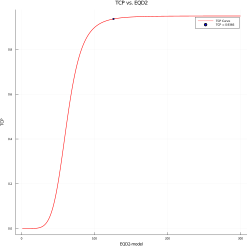

In [6]:
using Plots

function plot_tcp_curve()
    # Define the range of EQD2 values
    eqd2V = 1:300
    
    # Define parameters for TCP calculation
    TD_50 = 62.1
    gamma_50 = 1.5
    TCP_upper_bound = 0.95

    # Calculate TCP values
    tcpV = [TCP_upper_bound / (1 + (TD_50 / eqd2)^(4 * gamma_50)) for eqd2 in eqd2V]
    # Assuming Lung_TCP_Jeho is a function that takes fx_values and tx_days
    tcp = Lung_TCP_Jeho(fxValuesV, txDaysV)

    # Create the TCP curve plot
    plot(eqd2V, tcpV, color="red", linewidth=2, label="TCP Curve")
    scatter!((tcp[1], tcp[2]), color="blue", markersize=4, label="TCP = $(string(round(tcp[2], digits=4)))")
    
    # Customize plot layout
    xlabel!("EQD2-model")
    ylabel!("TCP")
    title!("TCP vs. EQD2")
    plot!(size=(1000, 1000))
end

plot_tcp_curve()
